TIME SERIES FORECASTING IN RETAIL INDUSTRY USING LSTM

# Data Analysis & Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
!pip install -U kaleido
import plotly.express as px

<ipython-input-1-153d3b894166>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df= pd.read_csv('/content/Updated Dataset.csv')
df

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD3324,Jackson,Bakery,Breads & Buns,Salem,03-01-2019,Central,864,0.26,380.16,Tamil Nadu
1,OD740,Haseena,Bakery,Cakes,Nagercoil,04-01-2019,Central,2033,0.15,325.28,Tamil Nadu
2,OD741,Vinne,Beverages,Health Drinks,Trichy,04-01-2019,Central,698,0.32,223.36,Tamil Nadu
3,OD742,Sudha,Snacks,Chocolates,Dharmapuri,04-01-2019,Central,759,0.27,174.57,Tamil Nadu
4,OD3873,Verma,"Eggs, Meat & Fish",Fish,Tirunelveli,05-01-2019,East,878,0.35,149.26,Tamil Nadu
...,...,...,...,...,...,...,...,...,...,...,...
9989,OD7774,Shree,Food Grains,Organic Staples,Perambalur,30-12-2022,West,548,0.25,164.40,Tamil Nadu
9990,OD7775,Anu,Oil & Masala,Edible Oil & Ghee,Bodi,30-12-2022,West,997,0.20,438.68,Tamil Nadu
9991,OD907,Veena,Snacks,Chocolates,Tirunelveli,30-12-2022,East,1240,0.34,458.80,Tamil Nadu
9992,OD908,Arvind,Snacks,Cookies,Ooty,30-12-2022,East,1854,0.20,685.98,Tamil Nadu


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Customer Name  9994 non-null   object 
 2   Category       9994 non-null   object 
 3   Sub Category   9994 non-null   object 
 4   City           9994 non-null   object 
 5   Order Date     9994 non-null   object 
 6   Region         9994 non-null   object 
 7   Sales          9994 non-null   int64  
 8   Discount       9994 non-null   float64
 9   Profit         9994 non-null   float64
 10  State          9994 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 859.0+ KB


In [ ]:
df['order_date'] = pd.to_datetime(df['Order Date'],infer_datetime_format=True)
df=df.drop('Order Date', axis=1)

/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime

In [ ]:
df.shape

(9994, 11)

In [ ]:
df.columns

Index(['Order ID', 'Customer Name', 'Category', 'Sub Category', 'City',
       'Region', 'Sales', 'Discount', 'Profit', 'State', 'order_date'],
      dtype='object')

In [ ]:
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
df.columns

Index(['order_id', 'customer_name', 'category', 'sub_category', 'city',
       'region', 'sales', 'discount', 'profit', 'state', 'order_date'],
      dtype='object')

In [ ]:
df.describe()

,sales,discount,profit
count,9994.000000,9994.000000,9994.000000
mean,1496.603362,0.226817,374.937082
std,577.565552,0.074636,239.932881
min,500.000000,0.100000,25.250000
25%,1000.000000,0.160000,180.022500
50%,1498.000000,0.230000,320.780000
75%,1994.750000,0.290000,525.627500
max,2500.000000,0.350000,1120.950000


In [ ]:
for c in df.columns:
    if len(set(df[c]))<25:
        print(c,set(df[c]))

category {'Beverages', 'Food Grains', 'Bakery', 'Fruits & Veggies', 'Eggs, Meat & Fish', 'Oil & Masala', 'Snacks'}
sub_category {'Mutton', 'Edible Oil & Ghee', 'Spices', 'Health Drinks', 'Noodles', 'Chicken', 'Fresh Fruits', 'Eggs', 'Soft Drinks', 'Masalas', 'Dals & Pulses', 'Fresh Vegetables', 'Chocolates', 'Organic Staples', 'Organic Vegetables', 'Cookies', 'Fish', 'Organic Fruits', 'Biscuits', 'Breads & Buns', 'Atta & Flour', 'Rice', 'Cakes'}
city {'Ooty', 'Krishnagiri', 'Bodi', 'Kanyakumari', 'Vellore', 'Namakkal', 'Viluppuram', 'Ramanadhapuram', 'Trichy', 'Chennai', 'Perambalur', 'Karur', 'Tenkasi', 'Nagercoil', 'Theni', 'Pudukottai', 'Tirunelveli', 'Virudhunagar', 'Salem', 'Cumbum', 'Dindigul', 'Madurai', 'Dharmapuri', 'Coimbatore'}
region {'West', 'Central', 'South', 'East', 'North'}
state {'Tamil Nadu'}


Snacks               1514
Eggs, Meat & Fish    1490
Fruits & Veggies     1418
Bakery               1413
Beverages            1400
Food Grains          1398
Oil & Masala         1361
Name: category, dtype: int64


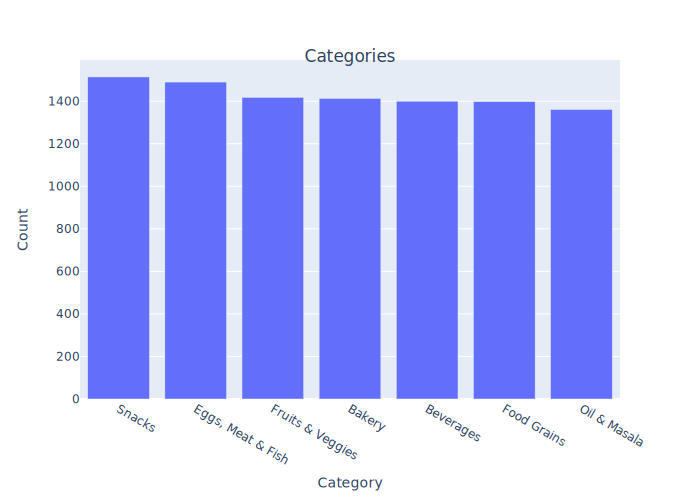

In [ ]:
ax = df['category'].value_counts()
fig = px.bar(ax, x=ax.index, y=ax.values, height=500)
fig.update_layout( title={
        'text': "Categories",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Category",
    yaxis_title="Count")
print(ax)
fig.show(renderer='svg')

Health Drinks         719
Soft Drinks           681
Cookies               520
Breads & Buns         502
Chocolates            499
Noodles               495
Masalas               463
Biscuits              459
Cakes                 452
Edible Oil & Ghee     451
Spices                447
Mutton                394
Eggs                  379
Organic Staples       372
Fresh Fruits          369
Fish                  369
Fresh Vegetables      354
Atta & Flour          353
Chicken               348
Organic Fruits        348
Organic Vegetables    347
Dals & Pulses         343
Rice                  330
Name: sub_category, dtype: int64


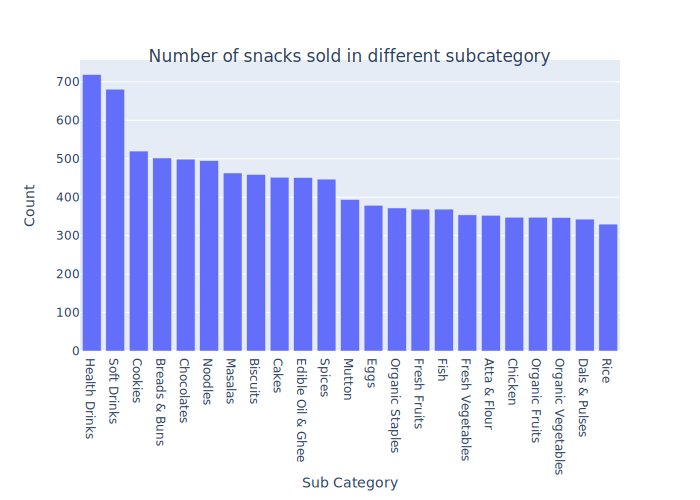

In [ ]:
bx = df['sub_category'].value_counts()
fig = px.bar(bx, x=bx.index, y=bx.values, height=500)
fig.update_layout( title={
        'text': "Number of snacks sold in different subcategory",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Sub Category",
    yaxis_title="Count")
print(bx)
fig.show(renderer='svg')

In [ ]:
main_snacks=df.loc[df['category'] == 'Snacks']

Cookies       520
Chocolates    499
Noodles       495
Name: sub_category, dtype: int64


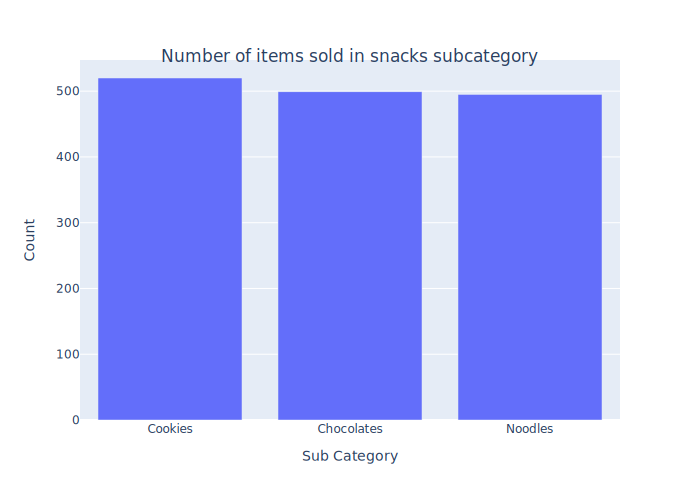

In [ ]:
sub = main_snacks['sub_category'].value_counts()
fig = px.bar(sub, x=sub.index, y=sub.values, height=500)
fig.update_layout( title={
        'text': "Number of items sold in snacks subcategory",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Sub Category",
    yaxis_title="Count")
print(sub)
fig.show(renderer='svg')

In [ ]:
snacks = main_snacks.groupby('order_date').agg({'sales': 'sum'}).reset_index()

In [ ]:
snacks = main_snacks.set_index('order_date')

In [ ]:
snacks.index

DatetimeIndex(['2019-04-01', '2019-06-01', '2019-06-01', '2019-06-01',
               '2019-01-13', '2019-01-19', '2019-01-26', '2019-01-26',
               '2019-01-28', '2019-02-02',
               ...
               '2022-12-24', '2022-12-25', '2022-12-25', '2022-12-25',
               '2022-12-26', '2022-12-28', '2022-12-28', '2022-12-30',
               '2022-12-30', '2022-12-30'],
              dtype='datetime64[ns]', name='order_date', length=1514, freq=None)

In [ ]:
snacks

,order_id,customer_name,category,sub_category,city,region,sales,discount,profit,state
order_date,,,,,,,,,,
2019-04-01,OD742,Sudha,Snacks,Chocolates,Dharmapuri,Central,759,0.27,174.57,Tamil Nadu
2019-06-01,OD8635,Hussain,Snacks,Cookies,Pudukottai,South,1504,0.23,616.64,Tamil Nadu
2019-06-01,OD9387,Akash,Snacks,Noodles,Chennai,South,1495,0.19,194.35,Tamil Nadu
2019-06-01,OD9418,Vince,Snacks,Noodles,Karur,South,2157,0.18,258.84,Tamil Nadu
2019-01-13,OD767,Arutra,Snacks,Noodles,Nagercoil,South,1903,0.11,666.05,Tamil Nadu
...,...,...,...,...,...,...,...,...,...,...
2022-12-28,OD271,Esther,Snacks,Noodles,Theni,West,764,0.11,160.44,Tamil Nadu
2022-12-28,OD9124,Peer,Snacks,Chocolates,Trichy,Central,1250,0.13,525.00,Tamil Nadu
2022-12-30,OD907,Veena,Snacks,Chocolates,Tirunelveli,East,1240,0.34,458.80,Tamil Nadu


In [ ]:
avg_snacks_sales = snacks['sales'].resample('MS').mean()
avg_snacks_sales

order_date
2019-01-01    1414.315789
2019-02-01    1276.437500
2019-03-01    1621.500000
2019-04-01    1257.238095
2019-05-01    1502.136364
2019-06-01    1470.480000
2019-07-01    1610.708333
2019-08-01    1486.666667
2019-09-01    1383.888889
2019-10-01    1781.107143
2019-11-01    1473.190476
2019-12-01    1542.891892
2020-01-01    1643.357143
2020-02-01    1620.142857
2020-03-01    1570.666667
2020-04-01    1243.913043
2020-05-01    1386.789474
2020-06-01    1300.451613
2020-07-01    1410.466667
2020-08-01    1517.130435
2020-09-01    1376.900000
2020-10-01    1367.722222
2020-11-01    1555.361111
2020-12-01    1312.315789
2021-01-01    1381.181818
2021-02-01    1493.818182
2021-03-01    1339.743590
2021-04-01    1298.107143
2021-05-01    1603.846154
2021-06-01    1266.793103
2021-07-01    1559.956522
2021-08-01    1632.129032
2021-09-01    1573.727273
2021-10-01    1353.800000
2021-11-01    1450.122449
2021-12-01    1443.285714
2022-01-01    1386.555556
2022-02-01    1581.787879
2

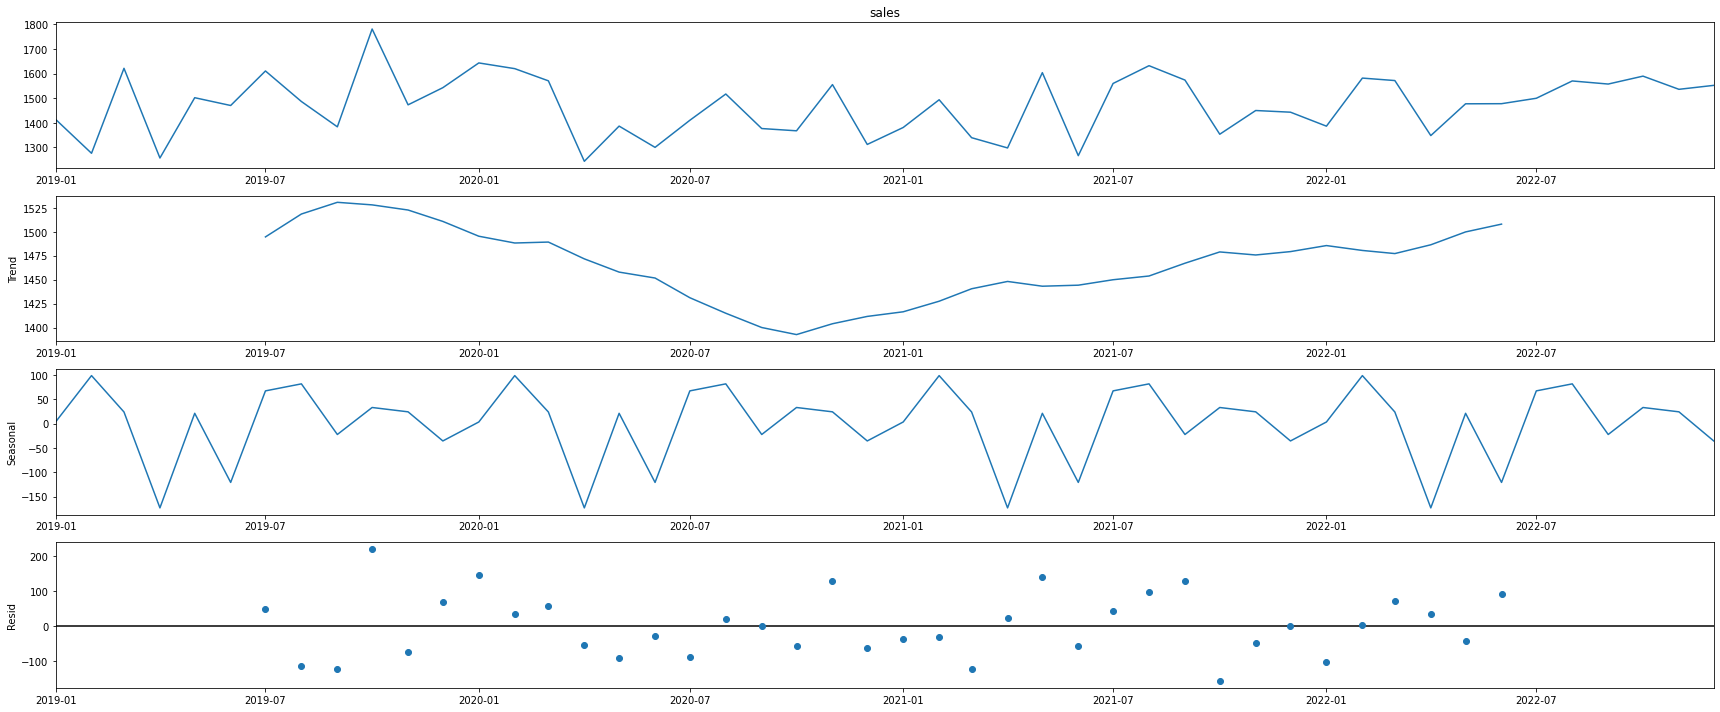

In [ ]:
rcParams['figure.figsize'] = 24, 10
decomposed_model = sm.tsa.seasonal_decompose(avg_snacks_sales, model='additive')
fig = decomposed_model.plot()
plt.show()

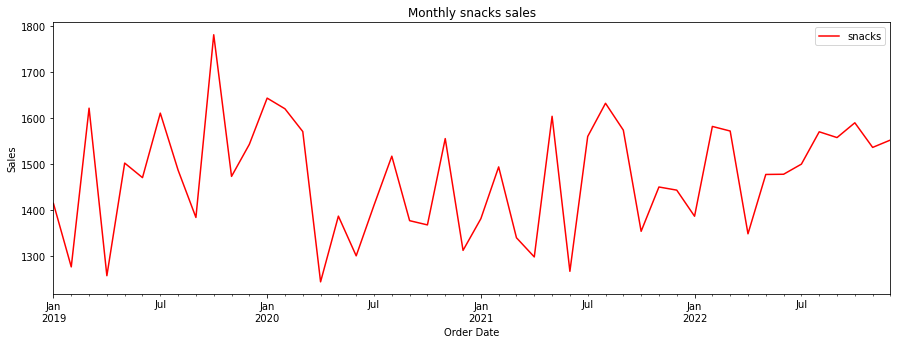

In [ ]:
avg_snacks_sales.plot(figsize=(15, 5),color='red',label = 'snacks')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly snacks sales")
plt.legend()
plt.show()

In [ ]:
def performance(y_true, y_pred):
    squared_errors = (y_pred - y_true) ** 2
    mse = squared_errors.mean()
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    results = {
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }
    
    return results

# Train & Test split

In [ ]:
train, test = np.array(avg_snacks_sales[:-12]), np.array(avg_snacks_sales[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
num_input = 12
num_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=num_input, batch_size=20)

# Vanilla LSTM

In [ ]:
n=20
arr1= np.zeros((12,n))
for i in range(n):
    vanilla_model = Sequential()
    vanilla_model.add(LSTM(50, activation='relu', input_shape=(12, 1)))
    vanilla_model.add(Dense(100, activation='relu'))
    vanilla_model.add(Dense(100, activation='relu'))
    vanilla_model.add(Dense(1))
    vanilla_model.compile(optimizer='adam', loss='mse')
    vanilla_model.fit_generator(generator,epochs=200)
    
    pred_list_v = []

    batch = train_scaled[-num_input:].reshape((1, num_input, num_features))

    for j in range(num_input):   
        pred_list_v.append(vanilla_model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_v[j]]],axis=1)

    df_predicted_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list_v),
                              index=avg_snacks_sales[-num_input:].index, columns=['Prediction'])

    
    arr1[:,i]=df_predicted_vanilla['Prediction']
print(arr1)

Epoch 1/200


<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 30ms/step - loss: 0.1843
Epoch 2/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1611
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1400
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1260
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1002
Epoch 6/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0877
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0669
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0591
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0540
Epoch 10/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0575
Epoch 11/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0649
Epoch 12/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0647
Epoch 13/200
2/2 [==============================] - 0s 25ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 6s 31ms/step - loss: 0.1876
Epoch 2/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1655
Epoch 3/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1326
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1123
Epoch 5/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0986
Epoch 6/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0745
Epoch 7/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0647
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0561
Epoch 9/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0591
Epoch 10/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0635
Epoch 11/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0658
Epoch 12/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0616
Epoch 13/200
2/2 [==============================] - 0s 28ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 19ms/step - loss: 0.1884
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1514
Epoch 3/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1346
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1047
Epoch 5/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0846
Epoch 6/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0727
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0570
Epoch 8/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0555
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0619
Epoch 10/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0660
Epoch 11/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0648
Epoch 12/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0601
Epoch 13/200
2/2 [==============================] - 0s 22ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 25ms/step - loss: 0.1979
Epoch 2/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1686
Epoch 3/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1373
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1164
Epoch 5/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0952
Epoch 6/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0816
Epoch 7/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0649
Epoch 8/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0547
Epoch 9/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0591
Epoch 10/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0639
Epoch 11/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0650
Epoch 12/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0621
Epoch 13/200
2/2 [==============================] - 0s 19ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 25ms/step - loss: 0.2129
Epoch 2/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1730
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1585
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1322
Epoch 5/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1191
Epoch 6/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0946
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0828
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0636
Epoch 9/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0571
Epoch 10/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0550
Epoch 11/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0585
Epoch 12/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0638
Epoch 13/200
2/2 [==============================] - 0s 23ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 23ms/step - loss: 0.1915
Epoch 2/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1750
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1475
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1344
Epoch 5/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1151
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0898
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0781
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0604
Epoch 9/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0556
Epoch 10/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0559
Epoch 11/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0619
Epoch 12/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0646
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 22ms/step - loss: 0.1796
Epoch 2/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1545
Epoch 3/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1328
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1180
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0970
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0777
Epoch 7/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0626
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0550
Epoch 9/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0607
Epoch 10/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0665
Epoch 11/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0649
Epoch 12/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0616
Epoch 13/200
2/2 [==============================] - 0s 31ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 27ms/step - loss: 0.1965
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1649
Epoch 3/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1403
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1138
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1007
Epoch 6/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0823
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0666
Epoch 8/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0566
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0558
Epoch 10/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0652
Epoch 11/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0669
Epoch 12/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0618
Epoch 13/200
2/2 [==============================] - 0s 21ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 19ms/step - loss: 0.1898
Epoch 2/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1499
Epoch 3/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1250
Epoch 4/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1033
Epoch 5/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0840
Epoch 6/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0727
Epoch 7/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0599
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0556
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0618
Epoch 10/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0651
Epoch 11/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0647
Epoch 12/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0603
Epoch 13/200
2/2 [==============================] - 0s 18ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 16ms/step - loss: 0.1732
Epoch 2/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1512
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 0.1226
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0901
Epoch 5/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0760
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0606
Epoch 7/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0550
Epoch 8/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0646
Epoch 9/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0687
Epoch 10/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0648
Epoch 11/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0610
Epoch 12/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0563
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 16ms/step - loss: 0.1719
Epoch 2/200
2/2 [==============================] - 0s 16ms/step - loss: 0.1482
Epoch 3/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1345
Epoch 4/200
2/2 [==============================] - 0s 16ms/step - loss: 0.1144
Epoch 5/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0951
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0724
Epoch 7/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0598
Epoch 8/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0548
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0564
Epoch 10/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0632
Epoch 11/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0648
Epoch 12/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0623
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 17ms/step - loss: 0.1852
Epoch 2/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1452
Epoch 3/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1280
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0981
Epoch 5/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0787
Epoch 6/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0677
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0555
Epoch 8/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0561
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0652
Epoch 10/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0663
Epoch 11/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0626
Epoch 12/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0577
Epoch 13/200
2/2 [==============================] - 0s 18ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 17ms/step - loss: 0.2021
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1693
Epoch 3/200
2/2 [==============================] - 0s 16ms/step - loss: 0.1509
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1346
Epoch 5/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1181
Epoch 6/200
2/2 [==============================] - 0s 15ms/step - loss: 0.1010
Epoch 7/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0896
Epoch 8/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0696
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0616
Epoch 10/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0549
Epoch 11/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0591
Epoch 12/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0632
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 19ms/step - loss: 0.1949
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1718
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1479
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1313
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1147
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1031
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0858
Epoch 8/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0695
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0578
Epoch 10/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0554
Epoch 11/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0633
Epoch 12/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0674
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 19ms/step - loss: 0.1827
Epoch 2/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1568
Epoch 3/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1430
Epoch 4/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1242
Epoch 5/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1055
Epoch 6/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0875
Epoch 7/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0669
Epoch 8/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0594
Epoch 9/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0550
Epoch 10/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0605
Epoch 11/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0648
Epoch 12/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0632
Epoch 13/200
2/2 [==============================] - 0s 26ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 24ms/step - loss: 0.1716
Epoch 2/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1365
Epoch 3/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1081
Epoch 4/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0843
Epoch 5/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0661
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0561
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0566
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0631
Epoch 9/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0655
Epoch 10/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0605
Epoch 11/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0576
Epoch 12/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0545
Epoch 13/200
2/2 [==============================] - 0s 26ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 24ms/step - loss: 0.1841
Epoch 2/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1521
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1334
Epoch 4/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1014
Epoch 5/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0803
Epoch 6/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0685
Epoch 7/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0554
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0551
Epoch 9/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0607
Epoch 10/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0646
Epoch 11/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0626
Epoch 12/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0582
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 19ms/step - loss: 0.1744
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1501
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1281
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1136
Epoch 5/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0870
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0749
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0610
Epoch 8/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0551
Epoch 9/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0606
Epoch 10/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0645
Epoch 11/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0642
Epoch 12/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0597
Epoch 13/200
2/2 [==============================] - 0s 18ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 17ms/step - loss: 0.1654
Epoch 2/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1354
Epoch 3/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1101
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0951
Epoch 5/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0760
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0586
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0555
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0608
Epoch 9/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0653
Epoch 10/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0648
Epoch 11/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0607
Epoch 12/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0567
Epoch 13/200
2/2 [==============================] - 0s 20ms/s

<ipython-input-25-b9d1f6ed1447>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 2s 21ms/step - loss: 0.1726
Epoch 2/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1313
Epoch 3/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1056
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0902
Epoch 5/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0708
Epoch 6/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0580
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0576
Epoch 8/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0624
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0660
Epoch 10/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0615
Epoch 11/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0570
Epoch 12/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0547
Epoch 13/200
2/2 [==============================] - 0s 16ms/s

In [ ]:
final_v= np.zeros((arr1.shape[0],1))
for i in range(arr1.shape[0]):
    
    final_v[i]=np.mean(arr1[i,:])
final_v=final_v.reshape((12,))

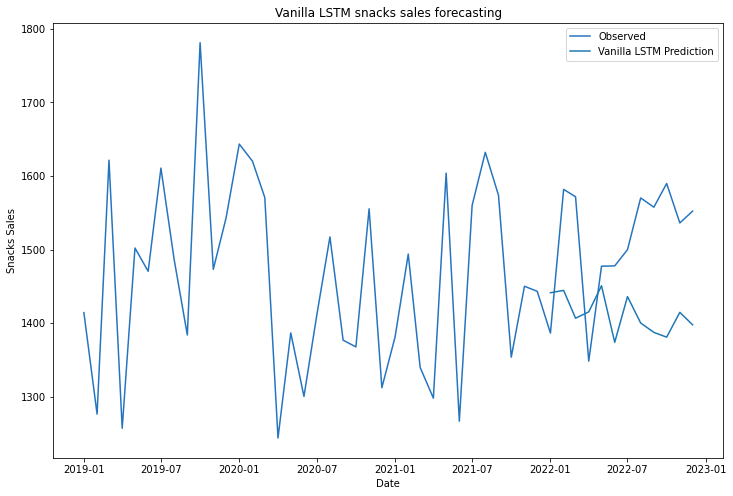

In [ ]:
rcParams['figure.figsize'] = 12, 8
plt.plot(avg_snacks_sales.index,avg_snacks_sales,label="Observed",color='#2574BF')
plt.plot(avg_snacks_sales[36:].index,final_v,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM snacks sales forecasting')
plt.xlabel('Date')
plt.ylabel('Snacks Sales')
plt.legend()
plt.show()

In [ ]:
vanilla_lstm= performance(avg_snacks_sales[-12:],final_v)
vanilla_lstm

{'MSE': 17428.6, 'RMSE': 132.02, 'MAPE': 7.83}

# Stacked LSTM

In [ ]:
n=20
arr2= np.zeros((12,n))
for i in range(n):
    stacked_model = Sequential()
    stacked_model.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
    stacked_model.add(LSTM(50, activation='relu'))
    stacked_model.add(Dense(100, activation='relu'))
    stacked_model.add(Dense(50, activation='relu'))
    stacked_model.add(Dense(1))
    stacked_model.compile(optimizer='adam', loss='mse')
    stacked_model.fit_generator(generator,epochs=200)
    
    pred_list_stack = []

    batch = train_scaled[-num_input:].reshape((1, num_input, num_features))

    for j in range(num_input):   
        pred_list_stack.append(stacked_model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_stack[j]]],axis=1)

    df_predicted_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_stack),
                              index=avg_snacks_sales[-num_input:].index, columns=['Prediction'])

    
    arr2[:,i]=df_predicted_stacked['Prediction'].values
print(arr2)

Epoch 1/200


<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 23ms/step - loss: 0.1960
Epoch 2/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1769
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1686
Epoch 4/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1546
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1325
Epoch 6/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1197
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0986
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0707
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0588
Epoch 10/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0604
Epoch 11/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0752
Epoch 12/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0699
Epoch 13/200
2/2 [==============================] - 0s 27ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 6s 28ms/step - loss: 0.1889
Epoch 2/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1642
Epoch 3/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1333
Epoch 4/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1172
Epoch 5/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0935
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0720
Epoch 7/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0568
Epoch 8/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0582
Epoch 9/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0697
Epoch 10/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0709
Epoch 11/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0608
Epoch 12/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0561
Epoch 13/200
2/2 [==============================] - 0s 31ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 21ms/step - loss: 0.1860
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1681
Epoch 3/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1573
Epoch 4/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1344
Epoch 5/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1215
Epoch 6/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1011
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0746
Epoch 8/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0630
Epoch 9/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0551
Epoch 10/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0651
Epoch 11/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0729
Epoch 12/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0680
Epoch 13/200
2/2 [==============================] - 0s 21ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 34ms/step - loss: 0.1802
Epoch 2/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1661
Epoch 3/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1436
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1089
Epoch 5/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0814
Epoch 6/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0650
Epoch 7/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0563
Epoch 8/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0835
Epoch 9/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0758
Epoch 10/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0666
Epoch 11/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0555
Epoch 12/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0559
Epoch 13/200
2/2 [==============================] - 0s 36ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 8s 22ms/step - loss: 0.1910
Epoch 2/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1758
Epoch 3/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1646
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1564
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1430
Epoch 6/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1275
Epoch 7/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1040
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0849
Epoch 9/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0724
Epoch 10/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0583
Epoch 11/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0663
Epoch 12/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0759
Epoch 13/200
2/2 [==============================] - 0s 25ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 25ms/step - loss: 0.1994
Epoch 2/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1804
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1655
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1445
Epoch 5/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1324
Epoch 6/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1065
Epoch 7/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0854
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0663
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0570
Epoch 10/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0590
Epoch 11/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0753
Epoch 12/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0702
Epoch 13/200
2/2 [==============================] - 0s 24ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 30ms/step - loss: 0.1928
Epoch 2/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1765
Epoch 3/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1627
Epoch 4/200
2/2 [==============================] - 0s 39ms/step - loss: 0.1421
Epoch 5/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1246
Epoch 6/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1118
Epoch 7/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0921
Epoch 8/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0725
Epoch 9/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0565
Epoch 10/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0570
Epoch 11/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0691
Epoch 12/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0708
Epoch 13/200
2/2 [==============================] - 0s 28ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 25ms/step - loss: 0.1808
Epoch 2/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1657
Epoch 3/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1459
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1260
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0984
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0848
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0632
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0568
Epoch 9/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0658
Epoch 10/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0746
Epoch 11/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0709
Epoch 12/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0627
Epoch 13/200
2/2 [==============================] - 0s 24ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 7s 31ms/step - loss: 0.1935
Epoch 2/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1663
Epoch 3/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1483
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1353
Epoch 5/200
2/2 [==============================] - 0s 40ms/step - loss: 0.1150
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0869
Epoch 7/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0677
Epoch 8/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0580
Epoch 9/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0633
Epoch 10/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0738
Epoch 11/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0693
Epoch 12/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0637
Epoch 13/200
2/2 [==============================] - 0s 41ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 24ms/step - loss: 0.1888
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1637
Epoch 3/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1528
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1298
Epoch 5/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1109
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0977
Epoch 7/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0728
Epoch 8/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0623
Epoch 9/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0552
Epoch 10/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0629
Epoch 11/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0720
Epoch 12/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0683
Epoch 13/200
2/2 [==============================] - 0s 26ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 24ms/step - loss: 0.1858
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1583
Epoch 3/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1437
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1204
Epoch 5/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0888
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0737
Epoch 7/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0580
Epoch 8/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0687
Epoch 9/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0758
Epoch 10/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0698
Epoch 11/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0642
Epoch 12/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0576
Epoch 13/200
2/2 [==============================] - 0s 24ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 39ms/step - loss: 0.2019
Epoch 2/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1816
Epoch 3/200
2/2 [==============================] - 0s 42ms/step - loss: 0.1675
Epoch 4/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1603
Epoch 5/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1486
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1310
Epoch 7/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1211
Epoch 8/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0999
Epoch 9/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0885
Epoch 10/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0720
Epoch 11/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0589
Epoch 12/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0598
Epoch 13/200
2/2 [==============================] - 0s 29ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 24ms/step - loss: 0.1862
Epoch 2/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1707
Epoch 3/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1511
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1313
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1040
Epoch 6/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0897
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0704
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0562
Epoch 9/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0566
Epoch 10/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0669
Epoch 11/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0693
Epoch 12/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0653
Epoch 13/200
2/2 [==============================] - 0s 26ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 25ms/step - loss: 0.1979
Epoch 2/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1780
Epoch 3/200
2/2 [==============================] - 0s 45ms/step - loss: 0.1599
Epoch 4/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1505
Epoch 5/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1356
Epoch 6/200
2/2 [==============================] - 0s 42ms/step - loss: 0.1193
Epoch 7/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1018
Epoch 8/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0841
Epoch 9/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0634
Epoch 10/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0563
Epoch 11/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0615
Epoch 12/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0701
Epoch 13/200
2/2 [==============================] - 0s 30ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 6s 34ms/step - loss: 0.1757
Epoch 2/200
2/2 [==============================] - 0s 39ms/step - loss: 0.1491
Epoch 3/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1309
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1041
Epoch 5/200
2/2 [==============================] - 0s 46ms/step - loss: 0.0726
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0586
Epoch 7/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0566
Epoch 8/200
2/2 [==============================] - 0s 43ms/step - loss: 0.0732
Epoch 9/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0741
Epoch 10/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0629
Epoch 11/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0591
Epoch 12/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0555
Epoch 13/200
2/2 [==============================] - 0s 32ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 24ms/step - loss: 0.1897
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1736
Epoch 3/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1566
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1376
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1164
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0940
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0725
Epoch 8/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0571
Epoch 9/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0661
Epoch 10/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0729
Epoch 11/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0666
Epoch 12/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0586
Epoch 13/200
2/2 [==============================] - 0s 32ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 34ms/step - loss: 0.1861
Epoch 2/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1644
Epoch 3/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1340
Epoch 4/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1097
Epoch 5/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0929
Epoch 6/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0703
Epoch 7/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0565
Epoch 8/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0625
Epoch 9/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0785
Epoch 10/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0705
Epoch 11/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0639
Epoch 12/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0556
Epoch 13/200
2/2 [==============================] - 0s 37ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 8s 26ms/step - loss: 0.1944
Epoch 2/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1735
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1595
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1436
Epoch 5/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1259
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1127
Epoch 7/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0851
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0715
Epoch 9/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0577
Epoch 10/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0609
Epoch 11/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0758
Epoch 12/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0721
Epoch 13/200
2/2 [==============================] - 0s 26ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 25ms/step - loss: 0.1897
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1691
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1423
Epoch 4/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1269
Epoch 5/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0940
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0776
Epoch 7/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0573
Epoch 8/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0656
Epoch 9/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0756
Epoch 10/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0686
Epoch 11/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0623
Epoch 12/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0550
Epoch 13/200
2/2 [==============================] - 0s 42ms/s

<ipython-input-29-be0ccff67393>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 44ms/step - loss: 0.1925
Epoch 2/200
2/2 [==============================] - 0s 39ms/step - loss: 0.1796
Epoch 3/200
2/2 [==============================] - 0s 40ms/step - loss: 0.1715
Epoch 4/200
2/2 [==============================] - 0s 38ms/step - loss: 0.1592
Epoch 5/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1461
Epoch 6/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1272
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1119
Epoch 8/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1011
Epoch 9/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0802
Epoch 10/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0660
Epoch 11/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0584
Epoch 12/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0558
Epoch 13/200
2/2 [==============================] - 0s 32ms/s

In [ ]:
final_stack= np.zeros((arr2.shape[0],1))
for i in range(arr2.shape[0]):
    
    final_stack[i]=np.mean(arr2[i,:])
final_stack=final_stack.reshape((12,))

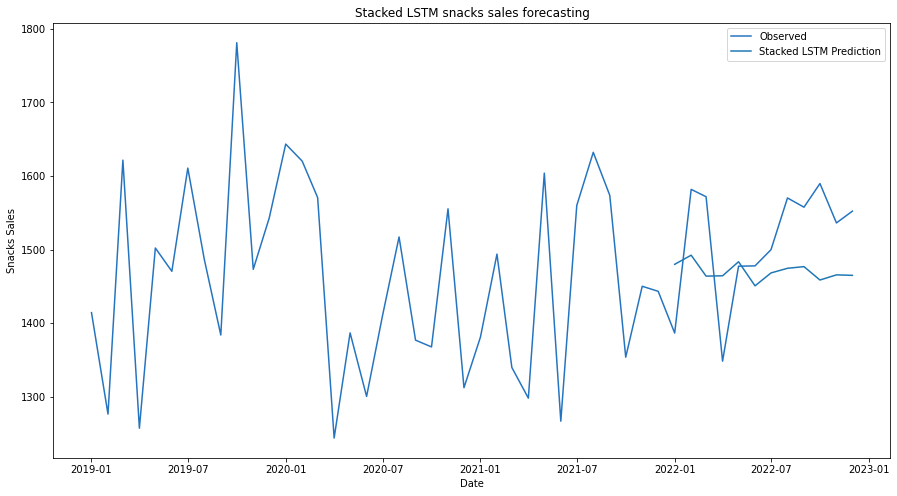

In [ ]:
rcParams['figure.figsize'] = 15, 8
plt.plot(avg_snacks_sales.index,avg_snacks_sales,label="Observed",color='#2574BF')
plt.plot(avg_snacks_sales[36:].index,final_stack,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM snacks sales forecasting')
plt.xlabel('Date')
plt.ylabel('Snacks Sales')
plt.legend()
plt.show()

In [ ]:
stacked_lstm= performance(avg_snacks_sales[-12:],final_stack)
stacked_lstm

{'MSE': 7419.42, 'RMSE': 86.14, 'MAPE': 5.16}

# Bi-Directional LSTM

In [ ]:
n=20
arr3= np.zeros((12,n))
for i in range(n):
  bi_model = Sequential()
  bi_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
  bi_model.add(Dense(1))
  bi_model.compile(optimizer='adam', loss='mse')
  bi_model.fit_generator(generator,epochs=200)
  pred_list_bi = []
  
  batch = train_scaled[-num_input:].reshape((1, num_input, num_features))

  for j in range(num_input):   
    pred_list_bi.append(bi_model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_bi[j]]],axis=1)
  
  df_predicted_bi = pd.DataFrame(scaler.inverse_transform(pred_list_bi),
                          index=avg_snacks_sales[-num_input:].index, columns=['Prediction'])
  
  arr3[:,i]=df_predicted_bi['Prediction'].values
print(arr3)

Epoch 1/200


<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 17ms/step - loss: 0.2888
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.2422
Epoch 3/200
2/2 [==============================] - 0s 20ms/step - loss: 0.2118
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1846
Epoch 5/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1603
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.1453
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1247
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1062
Epoch 9/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0850
Epoch 10/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0716
Epoch 11/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0640
Epoch 12/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0570
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 19ms/step - loss: 0.2138
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1882
Epoch 3/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1654
Epoch 4/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1449
Epoch 5/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1263
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1094
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0989
Epoch 8/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0810
Epoch 9/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0702
Epoch 10/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0622
Epoch 11/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0583
Epoch 12/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0581
Epoch 13/200
2/2 [==============================] - 0s 19ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 29ms/step - loss: 0.2265
Epoch 2/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1880
Epoch 3/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1632
Epoch 4/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1412
Epoch 5/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1211
Epoch 6/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1085
Epoch 7/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0868
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0771
Epoch 9/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0657
Epoch 10/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0583
Epoch 11/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0590
Epoch 12/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0613
Epoch 13/200
2/2 [==============================] - 0s 38ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 32ms/step - loss: 0.1792
Epoch 2/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1539
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1420
Epoch 4/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1204
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1104
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0968
Epoch 7/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0847
Epoch 8/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0742
Epoch 9/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0639
Epoch 10/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0597
Epoch 11/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0572
Epoch 12/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0593
Epoch 13/200
2/2 [==============================] - 0s 33ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 18ms/step - loss: 0.2022
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1761
Epoch 3/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1462
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1267
Epoch 5/200
2/2 [==============================] - 0s 18ms/step - loss: 0.1090
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0982
Epoch 7/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0841
Epoch 8/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0696
Epoch 9/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0622
Epoch 10/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0588
Epoch 11/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0606
Epoch 12/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0627
Epoch 13/200
2/2 [==============================] - 0s 17ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 21ms/step - loss: 0.1722
Epoch 2/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1430
Epoch 3/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1293
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1051
Epoch 5/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0938
Epoch 6/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0792
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0650
Epoch 8/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0591
Epoch 9/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0575
Epoch 10/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0610
Epoch 11/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0687
Epoch 12/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0694
Epoch 13/200
2/2 [==============================] - 0s 18ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 26ms/step - loss: 0.1921
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1781
Epoch 3/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1590
Epoch 4/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1412
Epoch 5/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1243
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1085
Epoch 7/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0892
Epoch 8/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0764
Epoch 9/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0687
Epoch 10/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0603
Epoch 11/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0568
Epoch 12/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0598
Epoch 13/200
2/2 [==============================] - 0s 35ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 6s 29ms/step - loss: 0.2006
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1705
Epoch 3/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1448
Epoch 4/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1230
Epoch 5/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1100
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0887
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0793
Epoch 8/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0684
Epoch 9/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0598
Epoch 10/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0574
Epoch 11/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0582
Epoch 12/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0622
Epoch 13/200
2/2 [==============================] - 0s 28ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 22ms/step - loss: 0.1757
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1628
Epoch 3/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1374
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1188
Epoch 5/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1069
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0857
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0762
Epoch 8/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0624
Epoch 9/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0572
Epoch 10/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0584
Epoch 11/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0612
Epoch 12/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0669
Epoch 13/200
2/2 [==============================] - 0s 35ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 35ms/step - loss: 0.2233
Epoch 2/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1943
Epoch 3/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1680
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1444
Epoch 5/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1171
Epoch 6/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1049
Epoch 7/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0840
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0749
Epoch 9/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0623
Epoch 10/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0578
Epoch 11/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0588
Epoch 12/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0610
Epoch 13/200
2/2 [==============================] - 0s 46ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 20ms/step - loss: 0.2060
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1897
Epoch 3/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1677
Epoch 4/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1421
Epoch 5/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1303
Epoch 6/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1140
Epoch 7/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0993
Epoch 8/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0823
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0716
Epoch 10/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0633
Epoch 11/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0583
Epoch 12/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0565
Epoch 13/200
2/2 [==============================] - 0s 22ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 3s 21ms/step - loss: 0.1761
Epoch 2/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1613
Epoch 3/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1415
Epoch 4/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1187
Epoch 5/200
2/2 [==============================] - 0s 19ms/step - loss: 0.1082
Epoch 6/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0944
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0822
Epoch 8/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0719
Epoch 9/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0625
Epoch 10/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0590
Epoch 11/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0573
Epoch 12/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0611
Epoch 13/200
2/2 [==============================] - 0s 19ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 8s 37ms/step - loss: 0.1672
Epoch 2/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1461
Epoch 3/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1328
Epoch 4/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1087
Epoch 5/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0928
Epoch 6/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0832
Epoch 7/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0714
Epoch 8/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0610
Epoch 9/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0577
Epoch 10/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0592
Epoch 11/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0637
Epoch 12/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0671
Epoch 13/200
2/2 [==============================] - 0s 30ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 22ms/step - loss: 0.1796
Epoch 2/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1599
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1417
Epoch 4/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1251
Epoch 5/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1101
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0927
Epoch 7/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0813
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0743
Epoch 9/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0657
Epoch 10/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0584
Epoch 11/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0569
Epoch 12/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0593
Epoch 13/200
2/2 [==============================] - 0s 24ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 26ms/step - loss: 0.1750
Epoch 2/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1627
Epoch 3/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1393
Epoch 4/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1283
Epoch 5/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1079
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0940
Epoch 7/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0814
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0735
Epoch 9/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0641
Epoch 10/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0581
Epoch 11/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0570
Epoch 12/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0643
Epoch 13/200
2/2 [==============================] - 0s 28ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 26ms/step - loss: 0.2146
Epoch 2/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1879
Epoch 3/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1636
Epoch 4/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1417
Epoch 5/200
2/2 [==============================] - 0s 38ms/step - loss: 0.1167
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1054
Epoch 7/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0906
Epoch 8/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0779
Epoch 9/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0678
Epoch 10/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0598
Epoch 11/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0574
Epoch 12/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0595
Epoch 13/200
2/2 [==============================] - 0s 45ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 29ms/step - loss: 0.1618
Epoch 2/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1417
Epoch 3/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1296
Epoch 4/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1084
Epoch 5/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0941
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0814
Epoch 7/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0707
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0646
Epoch 9/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0585
Epoch 10/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0565
Epoch 11/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0605
Epoch 12/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0628
Epoch 13/200
2/2 [==============================] - 0s 21ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 7s 26ms/step - loss: 0.2716
Epoch 2/200
2/2 [==============================] - 0s 28ms/step - loss: 0.2476
Epoch 3/200
2/2 [==============================] - 0s 25ms/step - loss: 0.2190
Epoch 4/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1999
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1824
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1663
Epoch 7/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1561
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1416
Epoch 9/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1277
Epoch 10/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1104
Epoch 11/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1019
Epoch 12/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0864
Epoch 13/200
2/2 [==============================] - 0s 26ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 5s 36ms/step - loss: 0.1567
Epoch 2/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1379
Epoch 3/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1159
Epoch 4/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1058
Epoch 5/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0920
Epoch 6/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0798
Epoch 7/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0670
Epoch 8/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0604
Epoch 9/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0577
Epoch 10/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0594
Epoch 11/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0635
Epoch 12/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0661
Epoch 13/200
2/2 [==============================] - 0s 37ms/s

<ipython-input-33-86f24d5a8bbf>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2/2 [==============================] - 4s 27ms/step - loss: 0.1917
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1738
Epoch 3/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1421
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1212
Epoch 5/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1031
Epoch 6/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0922
Epoch 7/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0753
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0658
Epoch 9/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0609
Epoch 10/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0579
Epoch 11/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0610
Epoch 12/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0632
Epoch 13/200
2/2 [==============================] - 0s 34ms/s

In [ ]:
final_bi= np.zeros((arr3.shape[0],1))
for i in range(arr3.shape[0]):
    
    final_bi[i]=np.mean(arr3[i,:])
final_bi=final_bi.reshape((12,))

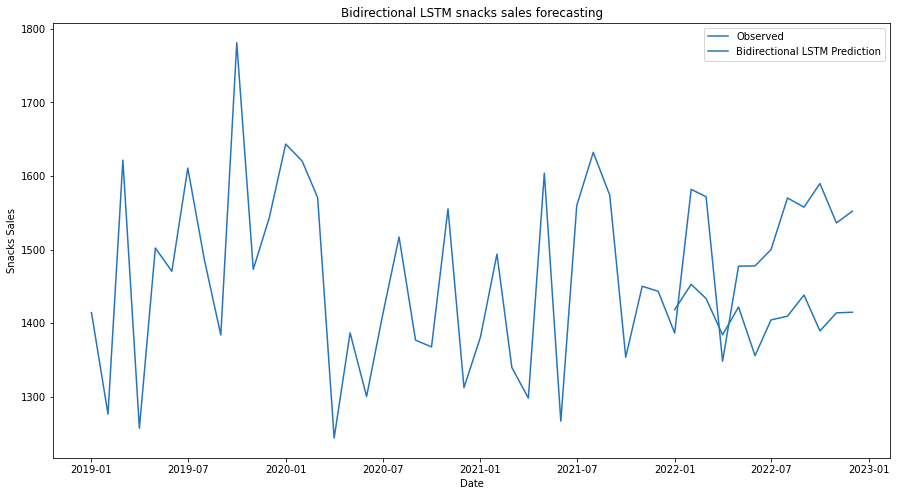

In [ ]:
rcParams['figure.figsize'] = 15, 8
plt.plot(avg_snacks_sales.index,avg_snacks_sales,label="Observed",color='#2574BF')
plt.plot(avg_snacks_sales[36:].index,final_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM snacks sales forecasting')
plt.xlabel('Date')
plt.ylabel('Snacks Sales')
plt.legend()
plt.show()

In [ ]:
bi_lstm= performance(avg_snacks_sales[-12:],final_bi )
bi_lstm

{'MSE': 14924.49, 'RMSE': 122.17, 'MAPE': 7.3}

# Evaluation

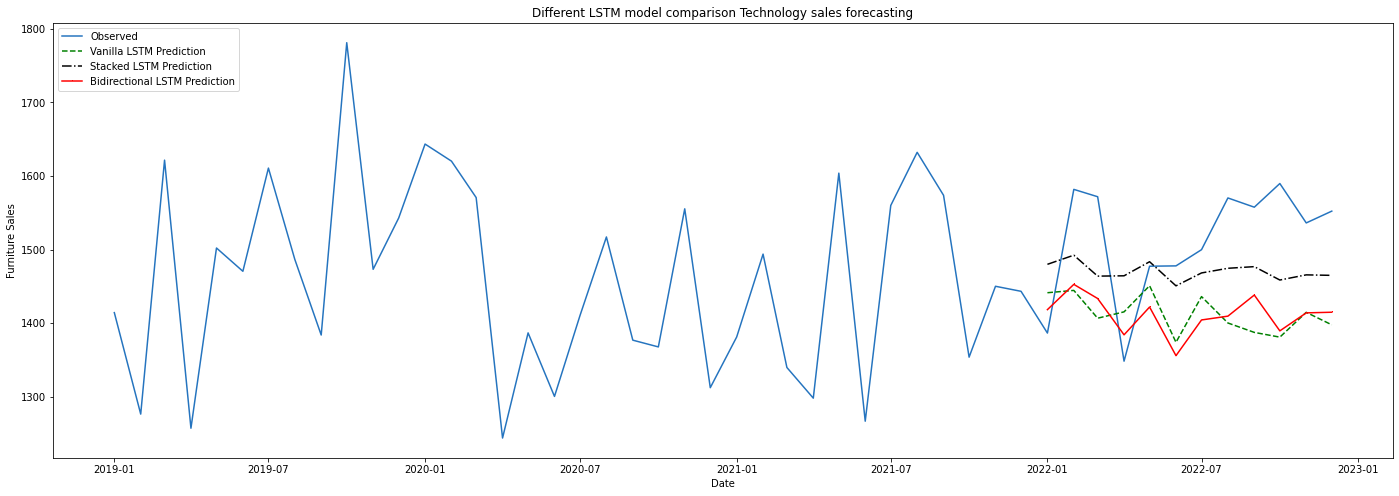

In [ ]:
rcParams['figure.figsize'] = 24, 8
plt.plot(avg_snacks_sales.index,avg_snacks_sales,label="Observed",color='#2574BF')
plt.plot(avg_snacks_sales[36:].index,final_v,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
plt.plot(avg_snacks_sales[36:].index,final_stack,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
plt.plot(avg_snacks_sales[36:].index,final_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison Technology sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

In [ ]:
predicted_data = {'Model':['Vanilla LSTM','Stacked LSTM','Bidirectional LSTM'],
                   
                    'MSE':[vanilla_lstm['MSE'],stacked_lstm['MSE'],bi_lstm['MSE']],
                  'RMSE':[vanilla_lstm['RMSE'],stacked_lstm['RMSE'],bi_lstm['RMSE']],
                  'MAPE':[vanilla_lstm['MAPE'],stacked_lstm['MAPE'],bi_lstm['MAPE']]}

predicted_table = pd.DataFrame(predicted_data)
predicted_table

,Model,MSE,RMSE,MAPE
0,Vanilla LSTM,17428.60,132.02,7.83
1,Stacked LSTM,7419.42,86.14,5.16
2,Bidirectional LSTM,14924.49,122.17,7.30


In [ ]:
predicted_data2 = {
        'Test Set':avg_snacks_sales[-12:],
        'Vanilla LSTM':final_v,
        'Stacked LSTM':final_stack,
        'Bidirectional LSTM':final_bi
        }

# Create DataFrame
predicted_table2 = pd.DataFrame(predicted_data2)
predicted_table2

,Test Set,Vanilla LSTM,Stacked LSTM,Bidirectional LSTM
order_date,,,,
2022-01-01,1386.555556,1441.352201,1479.949604,1418.365808
2022-02-01,1581.787879,1444.513512,1492.364597,1452.710871
2022-03-01,1571.796296,1406.732038,1463.911766,1433.496983
2022-04-01,1348.348837,1415.357039,1464.347983,1384.155212
2022-05-01,1477.387097,1450.857348,1483.468456,1421.912755
2022-06-01,1477.827586,1373.979675,1450.724112,1355.845774
2022-07-01,1499.848485,1436.101928,1468.242141,1404.347148
2022-08-01,1570.136364,1400.233710,1474.568323,1409.541809
2022-09-01,1557.583333,1387.456291,1476.803037,1438.199088


# Forecasting

In [ ]:
test_scaled

array([[0.26553254],
       [0.6289623 ],
       [0.61036272],
       [0.19440979],
       [0.43461768],
       [0.43543766],
       [0.47643011],
       [0.60727272],
       [0.58390494],
       [0.64376182],
       [0.5440937 ],
       [0.57393803]])

In [ ]:
n=1
pred_arr= np.zeros((12,n))
for i in range(n):
       
    test_list_s = []

    batch = test_scaled[-num_input:].reshape((1, num_input, num_features))

    for j in range(num_input):   
        test_list_s.append(stacked_model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[test_list_s[j]]],axis=1)

    df_forecasted_stacked = pd.DataFrame(scaler.inverse_transform(test_list_s),
                              index=avg_snacks_sales[-num_input:].index, columns=['Prediction'])

    
    pred_arr[:,i]=df_forecasted_stacked['Prediction']

print(pred_arr)

1/1 [==============================] - 0s 31ms/step
[[1482.61721298]
 [1445.25510314]
 [1468.75975604]
 [1454.20295035]
 [1416.90092466]
 [1425.22839865]
 [1449.43784356]
 [1489.21902477]
 [1519.96379347]
 [1530.73145553]
 [1534.50976063]
 [1531.70717854]]


In [ ]:
final_prediction= np.zeros((pred_arr.shape[0],1))
for i in range(pred_arr.shape[0]):
    
    final_prediction[i]=np.mean(pred_arr[i,:])
final_prediction=final_prediction.reshape((12,))

In [ ]:
final_prediction

array([1482.61721298, 1445.25510314, 1468.75975604, 1454.20295035,
       1416.90092466, 1425.22839865, 1449.43784356, 1489.21902477,
       1519.96379347, 1530.73145553, 1534.50976063, 1531.70717854])

In [ ]:
new_dates = pd.date_range('2019-01-01', periods=60, freq='MS')
avg_snacks_sales = avg_snacks_sales.reindex(new_dates)
avg_snacks_sales

2019-01-01    1414.315789
2019-02-01    1276.437500
2019-03-01    1621.500000
2019-04-01    1257.238095
2019-05-01    1502.136364
2019-06-01    1470.480000
2019-07-01    1610.708333
2019-08-01    1486.666667
2019-09-01    1383.888889
2019-10-01    1781.107143
2019-11-01    1473.190476
2019-12-01    1542.891892
2020-01-01    1643.357143
2020-02-01    1620.142857
2020-03-01    1570.666667
2020-04-01    1243.913043
2020-05-01    1386.789474
2020-06-01    1300.451613
2020-07-01    1410.466667
2020-08-01    1517.130435
2020-09-01    1376.900000
2020-10-01    1367.722222
2020-11-01    1555.361111
2020-12-01    1312.315789
2021-01-01    1381.181818
2021-02-01    1493.818182
2021-03-01    1339.743590
2021-04-01    1298.107143
2021-05-01    1603.846154
2021-06-01    1266.793103
2021-07-01    1559.956522
2021-08-01    1632.129032
2021-09-01    1573.727273
2021-10-01    1353.800000
2021-11-01    1450.122449
2021-12-01    1443.285714
2022-01-01    1386.555556
2022-02-01    1581.787879
2022-03-01  

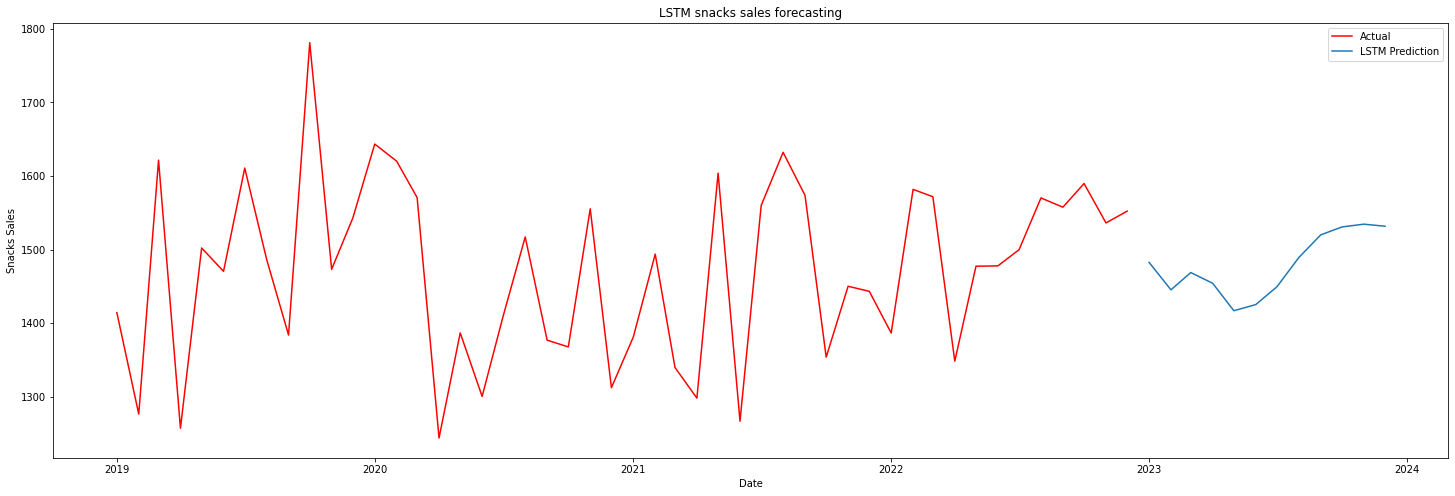

In [ ]:
rcParams['figure.figsize'] = 25, 8
plt.plot(avg_snacks_sales.index,avg_snacks_sales,label="Actual",color='red')
plt.plot(avg_snacks_sales[48:].index,final_prediction,label="LSTM Prediction")
plt.title('LSTM snacks sales forecasting')
plt.xlabel('Date')
plt.ylabel('Snacks Sales')
plt.legend()
plt.show()

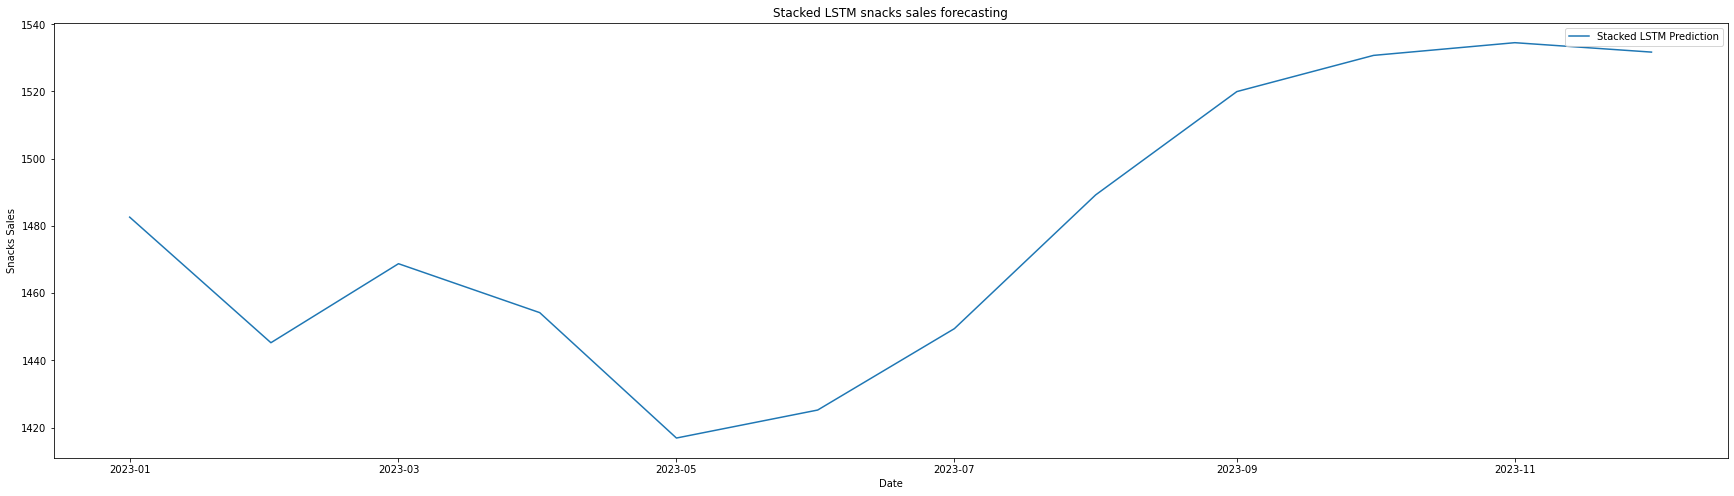

In [ ]:
rcParams['figure.figsize'] = 30, 8
plt.plot(avg_snacks_sales[48:].index,final_prediction,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM snacks sales forecasting')
plt.xlabel('Date')
plt.ylabel('Snacks Sales')
plt.legend()
plt.show()

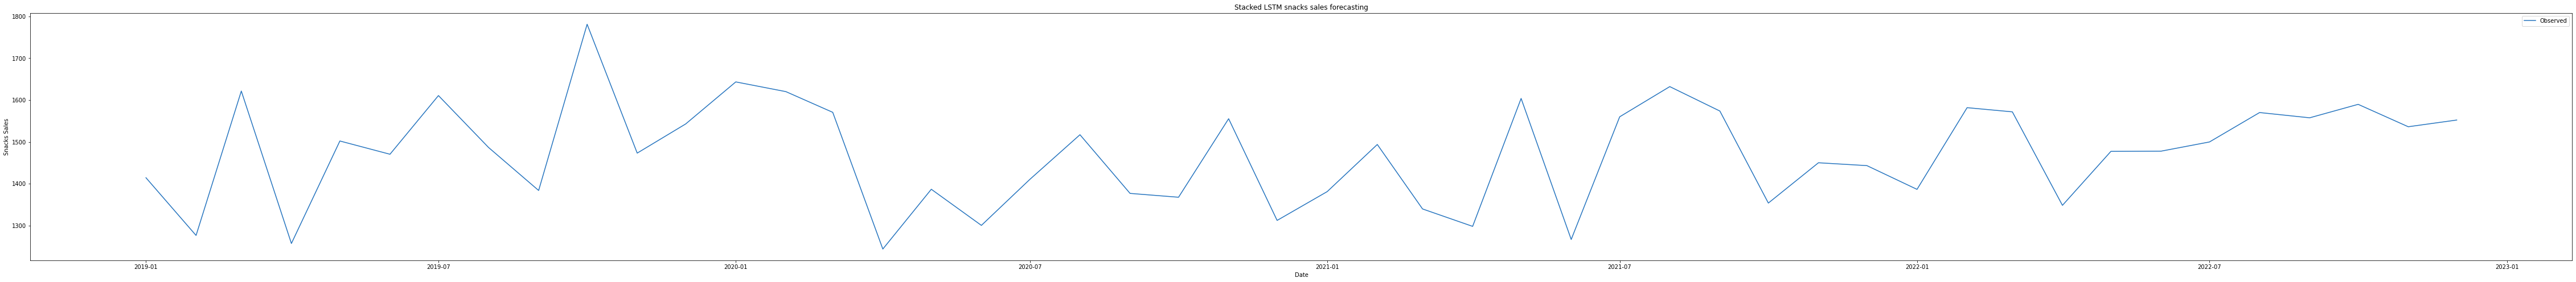

In [ ]:
rcParams['figure.figsize'] = 80, 8
plt.plot(avg_snacks_sales.index,avg_snacks_sales,label="Observed",color='#2574BF')
plt.title('Stacked LSTM snacks sales forecasting')
plt.xlabel('Date')
plt.ylabel('Snacks Sales')
plt.legend()
plt.show()